<a href="https://colab.research.google.com/github/ykwang/How-do-I-train-the-kaggle-data-in-colab-/blob/master/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
    token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
    token_file = os.path.join(token_dir, "kaggle.json")
    if not os.path.isdir(token_dir):
        os.mkdir(token_dir)
    try:
        with open(token_file,'r') as f:
            pass
    except IOError as no_file:
        try:
            from google.colab import files
        except ImportError:
            raise no_file

        uploaded = files.upload()

        if "kaggle.json" not in uploaded:
            raise ValueError("You need an API key! see: "
                           "https://github.com/Kaggle/kaggle-api#api-credentials")
        with open(token_file, "wb") as f:
            f.write(uploaded["kaggle.json"])
        os.chmod(token_file, 600)

get_kaggle_credentials()

Saving kaggle.json to kaggle.json


In [0]:
!pip install kaggle
import kaggle
# This will download the data (600 MB)
competition_name = 'Humpback-Whale-Identification'

kaggle.api.competition_download_file(competition_name, file_name='train.zip')
kaggle.api.competition_download_file(competition_name, file_name='test.zip')
kaggle.api.competition_download_file(competition_name, file_name='train.csv')

  0%|          | 0.00/4.16G [00:00<?, ?B/s]

100%|██████████| 4.16G/4.16G [01:02<00:00, 71.3MB/s]


  0%|          | 0.00/1.35G [00:00<?, ?B/s]

100%|██████████| 1.35G/1.35G [00:17<00:00, 84.3MB/s]


100%|██████████| 594k/594k [00:00<00:00, 185MB/s]

In [0]:
!mkdir -p input/train/&& mkdir -p input/test
!mv train.zip input/train/train.zip&& mv test.zip input/test/test.zip
!mv train.csv input/train.csv

In [0]:
!cd input/train/ && unzip train.zip
!cd input/test/ && unzip test.zip

Archive:  train.zip
  inflating: 1cb7e70be.jpg           
  inflating: 85fbaaeee.jpg           
  inflating: 0df6c0ada.jpg           
  inflating: b45879784.jpg           
  inflating: 667c90122.jpg           
  inflating: d78425146.jpg           
  inflating: 52fb69ef4.jpg           
  inflating: e6b70421a.jpg           
  inflating: 57c35256c.jpg           
  inflating: fdda50025.jpg           
  inflating: b642373be.jpg           
  inflating: 38d49de1f.jpg           
  inflating: e0bc48ac2.jpg           
  inflating: 4e2cf9e48.jpg           
  inflating: 5c5e91098.jpg           
  inflating: d6a6539af.jpg           
  inflating: d102de015.jpg           
  inflating: 3308c3a19.jpg           
  inflating: dfbcd5e5b.jpg           
  inflating: b5bf598c6.jpg           
  inflating: 665c7dade.jpg           
  inflating: 1a9116d41.jpg           
  inflating: 2b4a4e5f7.jpg           
  inflating: 00fee3975.jpg           
  inflating: fad7fd94b.jpg           
  inflating: 6c6895185.jpg    

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import matplotlib.pyplot as plt
import random
from keras import backend as K


Using TensorFlow backend.


In [0]:
from keras.models import Model,Sequential
from keras.layers import Activation, Add, Input, Flatten, Dense, Dropout, Lambda,Conv2D, BatchNormalization,\
                         GlobalMaxPooling2D,MaxPooling2D,Concatenate,Reshape
from keras.optimizers import Adam,RMSprop
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenetv2 import MobileNetV2

In [0]:
IMG_ROW=IMG_COL=299
BASE_DIR='./input/train/'
labelpath='./input/train.csv'
traindata=pd.read_csv(labelpath)

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)
  
def compute_accuracy(y_true, y_pred): # numpy上的操作
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred): # Tensor上的操作
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
def kind_list(imgdata):
    kindlist=imgdata.groupby('Id').size()
    return kindlist.index

def fetch_all_kind_list(imgdata):
    kindlist=kind_list(imgdata)
    kindimgpathlist=[]
    for kind in kindlist:
        kindimgpathlist.append(list(imgdata['Image'][imgdata['Id']==kind]))
    return kindimgpathlist,kindlist

def fetch_kind_list_split(kindimgpathlist,split_size=0.8):
    trainkindimgpathlist=[]
    validkindimgpathlist=[]
    for pathlist in kindimgpathlist:
        if(len(pathlist)<=3):
            trainkindimgpathlist.append(pathlist)
            validkindimgpathlist.append(pathlist)
        else:
            trainkindimgpathlist.append(pathlist[:int(len(pathlist)*split_size)])
            validkindimgpathlist.append(pathlist[int(len(pathlist)*split_size):])
    return trainkindimgpathlist,validkindimgpathlist

In [0]:
def imgarr(imgpath):
    img=cv2.imread(imgpath)
    return img

In [0]:
def siamese_img_gen(BASE_DIR,IMG_ROW,IMG_COL,kindimgpathlist,
                    contrast_times=5,batch_size=50):
    while(True):
        imglist1=[]
        imglist2=[]
        labellist=[]
        for i in range(batch_size):
          for j in range(contrast_times):
                rndid=random.randint(0,len(kindimgpathlist)-1)
                if(i%2==0):
                    #print(len(kindimgpathlist[rndid]))
                    pair=np.random.randint(0,len(kindimgpathlist[rndid]),2)
                    imgpath1=kindimgpathlist[rndid][pair[0]]
                    imgpath2=kindimgpathlist[rndid][pair[1]]
                    labellist.append(1)
                else:
                    rndid1=random.randint(0,len(kindimgpathlist[rndid])-1)
                    imgpath1=kindimgpathlist[rndid][rndid1]
                    index1=random.choice([num for num in range(len(kindimgpathlist)) if num not in [rndid]])
                    rndid2=random.randint(0,len(kindimgpathlist[index1])-1)
                    imgpath2=kindimgpathlist[index1][rndid2]
                    labellist.append(0)
                img1=imgarr(BASE_DIR+imgpath1)
                img2=imgarr(BASE_DIR+imgpath2)
                img1=cv2.resize(img1,(IMG_ROW,IMG_COL))
                img2=cv2.resize(img2,(IMG_ROW,IMG_COL))
                imglist1.append(img1)
                imglist2.append(img2)
        yield ([np.asarray(imglist1),np.asarray(imglist2)],np.asarray(labellist))

In [0]:
img_shape=(IMG_ROW,IMG_COL,3)
resnet=ResNet50(include_top=False, weights= 'imagenet',
               input_tensor=None, pooling = 'avg')
for layer in resnet.layers:
  layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 8s 0us/step


In [0]:
f_base = resnet.get_layer(index = -1).output     # shape=(None, 1, 1, 2048)
        
input_a = Input(shape=img_shape)
input_b = Input(shape=img_shape)


f_acs = Dense(128, name='feature')(f_base)
branch_model = Model(inputs= resnet.input, outputs = f_acs)

processed_a = branch_model(input_a)
processed_b = branch_model(input_b)

mid = 32
xa_inp = Input(shape=branch_model.output_shape[1:])
xb_inp = Input(shape=branch_model.output_shape[1:])
x1 = Lambda(lambda x: x[0] * x[1])([xa_inp, xb_inp])
x2 = Lambda(lambda x: x[0] + x[1])([xa_inp, xb_inp])
x3 = Lambda(lambda x: K.abs(x[0] - x[1]))([xa_inp, xb_inp])
x4 = Lambda(lambda x: K.square(x))(x3)
x = Concatenate()([x1, x2, x3, x4])
x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

# Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
x = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
x = Reshape((branch_model.output_shape[1], mid, 1))(x)
x = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
x = Flatten(name='flatten')(x)

# Weighted sum implemented as a Dense layer.
x = Dense(1, use_bias=True, activation='sigmoid', name='weighted-average')(x)
distance_model = Model([xa_inp, xb_inp], x, name='distance')


distance  = distance_model([processed_a, processed_b])

model1 = Model([input_a, input_b], distance)


model1.summary()
optim = Adam(lr=6e-5)
model1.compile(optim, loss='binary_crossentropy', metrics=['acc'])
callbacks=[
    EarlyStopping(monitor='val_loss', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=5,min_lr=1e-9,verbose=1,mode='min'),
    ModelCheckpoint('siamese.h5',monitor='val_loss',save_best_only=True,verbose=1)
]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 128)          23849984    input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
distance (Model)                (None, 1)            322         model_5[1][0]                    
          

In [0]:
kindimgpathlist,kindlist=fetch_all_kind_list(traindata)
trainkindimgpathlist,validkindimgpathlist=fetch_kind_list_split(kindimgpathlist)

In [0]:
 history=model1.fit_generator(siamese_img_gen(BASE_DIR,IMG_ROW,IMG_COL,
                                            trainkindimgpathlist,batch_size=20),
                            steps_per_epoch=5,
                            epochs=100,
                            verbose = 1,
                            validation_data=siamese_img_gen(BASE_DIR,IMG_ROW,IMG_COL,
                                                            validkindimgpathlist,contrast_times=10,batch_size=5),
                            validation_steps=10,
                            callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - 54s 11s/step - loss: 0.6997 - acc: 0.4720 - val_loss: 0.6998 - val_acc: 0.4920

Epoch 00001: val_loss improved from inf to 0.69980, saving model to siamese.h5
Epoch 2/100
5/5 [==============================] - 30s 6s/step - loss: 0.6922 - acc: 0.5300 - val_loss: 0.6861 - val_acc: 0.5440

Epoch 00002: val_loss improved from 0.69980 to 0.68605, saving model to siamese.h5
Epoch 3/100
5/5 [==============================] - 30s 6s/step - loss: 0.6895 - acc: 0.5000 - val_loss: 0.6825 - val_acc: 0.5420

Epoch 00003: val_loss improved from 0.68605 to 0.68254, saving model to siamese.h5
Epoch 4/100
5/5 [==============================] - 30s 6s/step - loss: 0.6812 - acc: 0.5460 - val_loss: 0.6706 - val_acc: 0.5920

Epoch 00004: val_loss improved from 0.68254 to 0.67061, saving model to siamese.h5
Epoch 5/100
5/5 [==============================] - 30s 6s/step - loss: 0.6769 - acc: 0.5840 - val_loss: 0.6779 - val_acc: 0.5620

Epoch 00005: val_loss

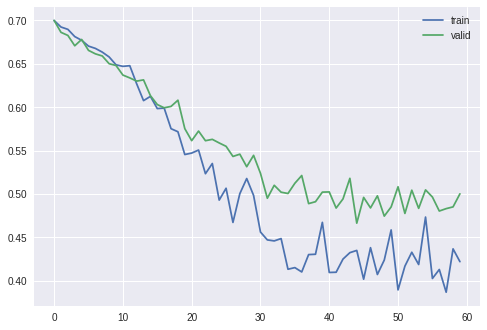

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','valid'])
plt.show()

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
model_path = 'siamese1.h5'
model.load_weights(model_path)

In [0]:
from glob import glob
from skimage.io import imread

TEST_DIR = './input/test/'
batch_size = 32
classes = traindata.Id.unique()
test_files = glob(os.path.join('./input/test/','*.jpg'))
max_idx = len(test_files)
test_df = pd.DataFrame({'path': test_files[:max_idx]})
test_df['Image'] = test_df.path.map(lambda x: x.split('/')[3]) 

In [0]:
def feature_gen(BASE_DIR,IMG_ROW,IMG_COL,imgpathlist,batch_size,current_index,train=True):
  imglist=[]
  N = len(imgpathlist)
    
  if N >= (current_index + batch_size):
    current_batch_size = batch_size
  else:
    current_batch_size = N - current_index
  for i in range(current_index,current_index+current_batch_size):
    if(train):
      rndid=random.randint(0,len(imgpathlist[i])-1)
      imgpath=imgpathlist[i][rndid]
    else :
      imgpath=imgpathlist[i]
    img=imgarr(BASE_DIR+imgpath)
    img=cv2.resize(img,(IMG_ROW,IMG_COL))
    imglist.append(img)
  return ([np.asarray(imglist)])
  


In [0]:
batch_size = 640
feature_labels = []
for idx in range(0,len(classes),batch_size):
  label = branch_model.predict(feature_gen(BASE_DIR='./input/train/',
      IMG_ROW=IMG_ROW,IMG_COL=IMG_COL,imgpathlist=kindimgpathlist,batch_size=batch_size,current_index=idx),verbose=1)
  feature_labels.extend(label)

525/525 [==============================] - 10s 19ms/step


In [0]:
batch_size = 1000
test_labels = []

for idx in range(0,max_idx,batch_size):
  label = branch_model.predict(feature_gen(BASE_DIR='./input/test/',
      IMG_ROW=IMG_ROW,IMG_COL=IMG_COL,imgpathlist=list(test_df['Image']),batch_size=batch_size,current_index=idx,train=False),verbose=1)
  test_labels.extend(label)

960/960 [==============================] - 16s 16ms/step


In [0]:
def distance_gen(X,Y,batch_size,current_index):
  N = len(Y)
  list1=[]
  list2=[]
  if N >= (current_index + batch_size):
    current_batch_size = batch_size
  else:
    current_batch_size = N - current_index
  for i in range(current_index,current_index+current_batch_size):
    list1.append(X)
    list2.append(Y[i])
  return ([np.asarray(list1),np.asarray(list2)])

In [29]:
batch_size = 5005
for i in range(0,max_idx,1):
  print("Indexes: %i/%i"%(i, max_idx))
  labels=[]
  for idx in range(0,len(classes),batch_size):
    predicted_labels = distance_model.predict(distance_gen(test_labels[i],feature_labels,batch_size,idx),verbose=1)
    labels.extend(predicted_labels)
  test_df.loc[i, 'Id']= ' '.join(kindlist[np.argsort(np.reshape(np.array(labels),(len(classes),)))[:5][::-1]])
  
submission1 = pd.DataFrame()
submission1 = pd.concat([submission1, test_df[["Image", "Id"]]])

submission1.to_csv('submission.csv', index=False, header=True) 

Indexes: 0/7960
5005/5005 [==============================] - 3s 578us/step
Indexes: 1/7960
5005/5005 [==============================] - 0s 92us/step
Indexes: 2/7960
5005/5005 [==============================] - 0s 92us/step
Indexes: 3/7960
5005/5005 [==============================] - 0s 93us/step
Indexes: 4/7960
5005/5005 [==============================] - 0s 90us/step
Indexes: 5/7960
5005/5005 [==============================] - 0s 93us/step
Indexes: 6/7960
5005/5005 [==============================] - 0s 91us/step
Indexes: 7/7960
5005/5005 [==============================] - 0s 94us/step
Indexes: 8/7960
5005/5005 [==============================] - 0s 91us/step
Indexes: 9/7960
5005/5005 [==============================] - 0s 92us/step
Indexes: 10/7960
5005/5005 [==============================] - 0s 90us/step
Indexes: 11/7960
5005/5005 [==============================] - 0s 90us/step
Indexes: 12/7960
5005/5005 [==============================] - 0s 92us/step
Indexes: 13/7960
5005/5005 [======